In [2]:
import pandas as pd
import numpy as np
from fitparse import FitFile
from datetime import timedelta
import matplotlib.pyplot as plt
import json
from collections import defaultdict


In [3]:
def parse_lyfta_csv(path, target_datetime, tolerance_minutes=180):
    df = pd.read_csv(path)
    df.columns = [c.strip() for c in df.columns]

    df['Date'] = pd.to_datetime(df['Date'])
    df['Superset id'] = df['Superset id'].astype('Int64')

    # Find closest workout by date
    df['time_diff_min'] = (df['Date'] - target_datetime).abs().dt.total_seconds() / 60
    closest_time = df.loc[df['time_diff_min'].idxmin(), 'Date']

    if df['time_diff_min'].min() > tolerance_minutes:
        raise ValueError("No Lyfta workout close enough to Garmin activity")

    # Filter ONLY that workout
    workout_df = df[df['Date'] == closest_time].copy()

    sets = []
    for _, row in workout_df.iterrows():
        sets.append({
            'exercise': row.get('Exercise'),
            'weight': row.get('Weight'),
            'reps': row.get('Reps'),
            'superset_id': row.get('Superset id')
        })

    return closest_time, sets


In [4]:
def reorder_lyfta_sets_for_execution(lyfta_sets):
    """
    Returns a new list of lyfta_sets reordered to match execution order,
    handling supersets via round-robin interleaving.
    """
    result = []
    i = 0
    n = len(lyfta_sets)

    while i < n:
        current = lyfta_sets[i]
        sid = current.get('superset_id')

        # Case 1: not a superset → keep order
        if pd.isna(sid) or sid == '' or sid is None:
            result.append(current)
            i += 1
            continue

        # Case 2: superset block
        block = []
        j = i
        while j < n and lyfta_sets[j].get('superset_id') == sid:
            block.append(lyfta_sets[j])
            j += 1

        # Group block by exercise
        by_exercise = defaultdict(list)
        for s in block:
            by_exercise[s['exercise']].append(s)

        # Round-robin interleave
        max_len = max(len(v) for v in by_exercise.values())
        exercises = list(by_exercise.keys())

        for k in range(max_len):
            for ex in exercises:
                if k < len(by_exercise[ex]):
                    result.append(by_exercise[ex][k])

        i = j

    return result

In [5]:
def parse_records_to_df(fit_path):
    fit = FitFile(fit_path)
    rows = []
    for rec in fit.get_messages('record'):
        r = {}
        for f in rec:
            if f.name == 'timestamp':
                r['timestamp'] = pd.to_datetime(f.value)
            else:
                try:
                    r[f.name] = float(f.value)
                except:
                    r[f.name] = None
        rows.append(r)

    df = pd.DataFrame(rows).dropna(subset=['timestamp'])
    df = df.sort_values('timestamp').reset_index(drop=True)
    return df


def extract_active_sets_from_fit(fit_path):
    fit = FitFile(fit_path)
    raw_sets = []
    for msg in fit.get_messages('set'):
        fields = {f.name: f.value for f in msg}
        raw_sets.append(fields)

    active = [s for s in raw_sets if str(s.get('set_type')).lower() == 'active']

    # build windows
    windows = []
    for s in active:
        start = pd.to_datetime(s['start_time'])
        dur = s.get('duration')
        if dur:
            end = start + pd.to_timedelta(float(dur), unit='s')
        else:
            end = start + pd.to_timedelta(20, unit='s')

        windows.append({
            'start': start,
            'end': end,
            'repetitions': s.get('repetitions'),
        })

    return sorted(windows, key=lambda w: w['start'])


In [6]:
def merge_garmin_lyfta(
    lyfta_start,
    lyfta_sets,
    garmin_sets,
    hr_df,
    tolerance_minutes=180
):
    # 🔁 REORDER LYFTA SETS FIRST
    lyfta_sets = reorder_lyfta_sets_for_execution(lyfta_sets)

    # workout timestamp match
    first_garmin = garmin_sets[0]['start']
    diff_min = abs((first_garmin - lyfta_start).total_seconds()) / 60

    if diff_min > tolerance_minutes:
        raise ValueError("Garmin activity not matching Lyfta workout timestamp.")

    merged = []
    skipped = []

    for i, gset in enumerate(garmin_sets):
        if i >= len(lyfta_sets):
            break

        ly = lyfta_sets[i]
        s, e = gset['start'], gset['end']

        slice_df = hr_df[
            (hr_df['timestamp'] >= s) &
            (hr_df['timestamp'] <= e)
        ]

        if slice_df.empty:
            skipped.append({**ly, 'reason': 'no HR samples'})
            continue

        merged.append({
            'set_index': i,
            'exercise': ly['exercise'],
            'weight': ly['weight'],
            'reps': ly['reps'],
            'superset_id': ly.get('superset_id'),
            'start': s,
            'end': e,
            'duration_s': (e - s).total_seconds(),
            'avg_hr': slice_df['heart_rate'].mean(),
            'max_hr': slice_df['heart_rate'].max(),
            'hr_samples': len(slice_df),
        })

    return pd.DataFrame(merged), pd.DataFrame(skipped)


In [7]:
def plot_set_hr(slice_df, set_index, exercise):
    plt.figure(figsize=(10,4))
    plt.plot(slice_df['timestamp'], slice_df['heart_rate'])
    plt.title(f"Set {set_index}: {exercise}")
    plt.xlabel("Time")
    plt.ylabel("HR (bpm)")
    plt.grid(True)
    plt.show()


In [8]:
def plot_full_workout_with_sets(hr_df, merged_df):
    plt.figure(figsize=(14,5))
    plt.plot(hr_df['timestamp'], hr_df['heart_rate'], label="HR", alpha=0.7)

    for _, row in merged_df.iterrows():
        plt.axvspan(row['start'], row['end'], alpha=0.2, label=f"{row['exercise']}")

    plt.title("Full Workout — HR with Set Sections Highlighted")
    plt.xlabel("Time")
    plt.ylabel("HR (bpm)")
    plt.grid(True)
    plt.show()


    set_index                        exercise  weight  reps superset_id  \
0           0                     Bench Press    10.0     6        <NA>   
1           1                     Bench Press    20.0     6        <NA>   
2           2                     Bench Press    25.0     6        <NA>   
3           3                     Bench Press    30.0     1        <NA>   
4           4  Dumbbell Seated Shoulder Press    15.0    10        <NA>   
5           5  Dumbbell Seated Shoulder Press    22.0     7        <NA>   
6           6            Single Arm Chest Fly    15.0    10        <NA>   
7           7            Single Arm Chest Fly    25.0    10        <NA>   
8           8                   Lateral Raise    10.0    12           1   
9           9              Lever Pec Deck Fly    40.0     9           1   
10         10                   Lateral Raise    10.0    10           1   

                 start                     end  duration_s      avg_hr  \
0  2025-12-08 11:16:21 20

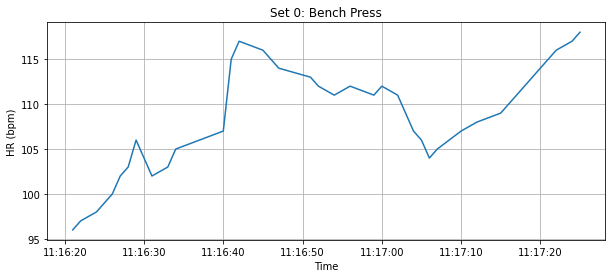

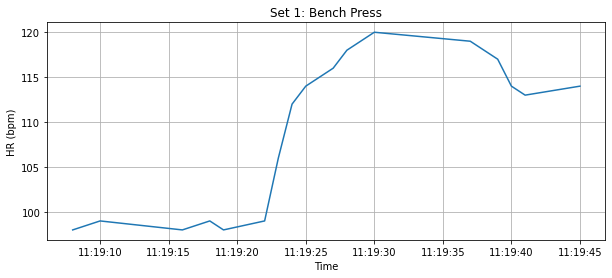

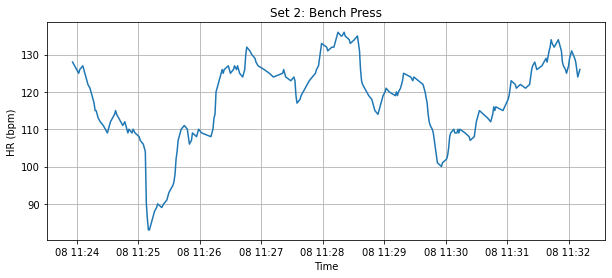

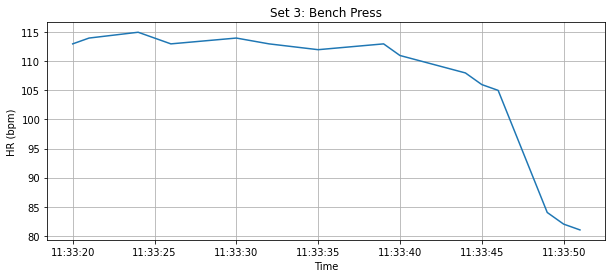

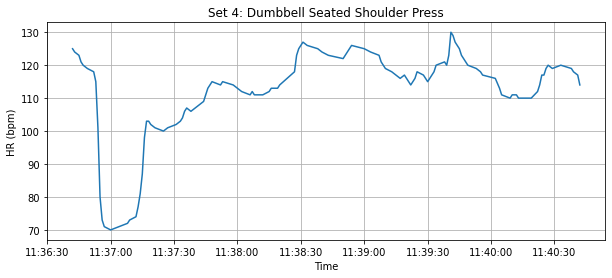

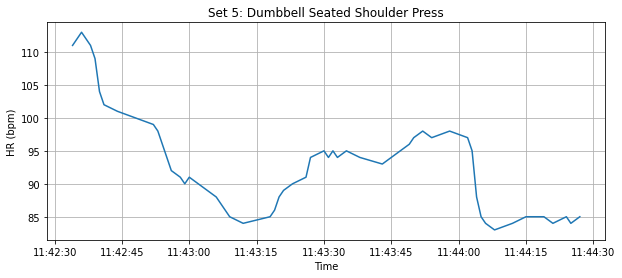

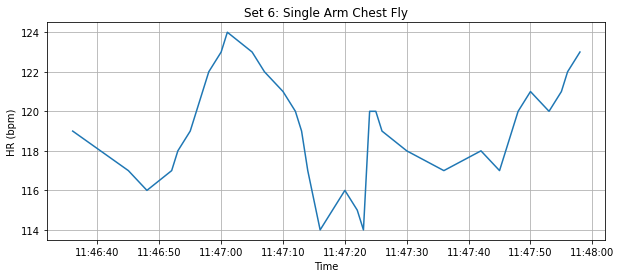

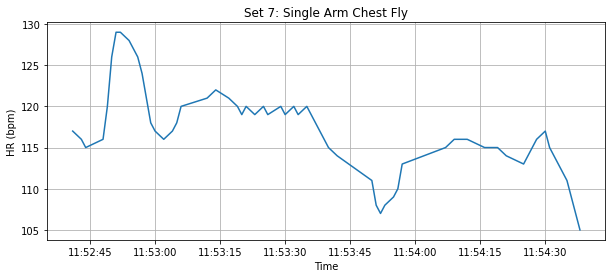

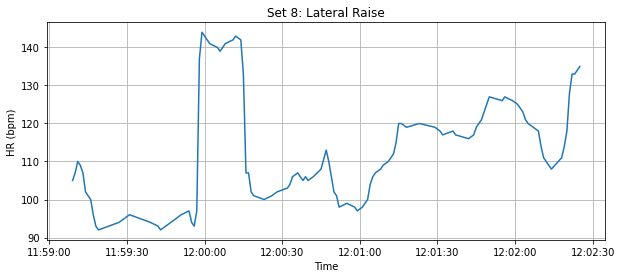

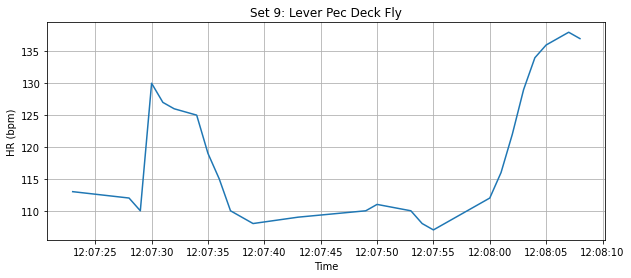

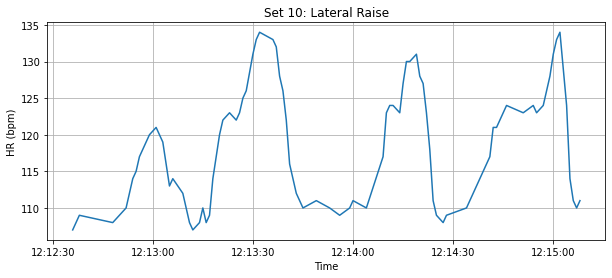

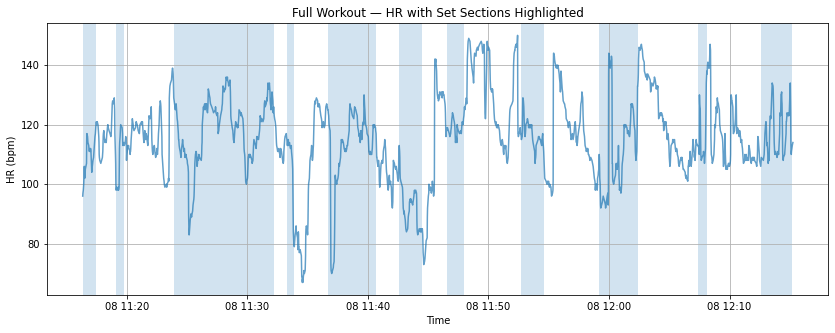

In [11]:
LYFTA_PATH = "demo/demo_lyfta.csv"
FIT_PATH2 = 'demo/21159045593_ACTIVITY.fit'
FIT_PATH = 'demo/21210521095_ACTIVITY.fit'

garmin_sets = extract_active_sets_from_fit(FIT_PATH)
garmin_start = garmin_sets[0]['start']

# Then pick the matching Lyfta workout
lyfta_start, lyfta_sets = parse_lyfta_csv(
    LYFTA_PATH,
    target_datetime=garmin_start
)

hr_df = parse_records_to_df(FIT_PATH)
garmin_sets = extract_active_sets_from_fit(FIT_PATH)

merged_df, skipped_df = merge_garmin_lyfta(lyfta_start, lyfta_sets, garmin_sets, hr_df)

merged_df.to_csv("merged_workout.csv", index=False)
print(merged_df)

# Show per-set graphs
for _, row in merged_df.iterrows():
    s, e = row['start'], row['end']
    slice_df = hr_df[(hr_df['timestamp'] >= s) & (hr_df['timestamp'] <= e)]
    plot_set_hr(slice_df, row['set_index'], row['exercise'])

# Show full workout graph
plot_full_workout_with_sets(hr_df, merged_df)
